In [41]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm

from sklearn.model_selection import GroupShuffleSplit
from bisect import bisect
from sklearn.metrics import mean_squared_error

from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModel

import torch.nn as nn
import copy

from tqdm import tqdm
import sys, os
from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch

from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer

import time

import matplotlib.pyplot as plt


In [15]:
pd.options.display.width = 180
pd.options.display.max_colwidth = 120

bert = AutoModel.from_pretrained("microsoft/codebert-base")
data_dir = Path('../input/ai4code')

In [16]:
#Read dataset
def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id'))

In [17]:
#Get the kendall tau corelation values
def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max

In [ ]:
#Get the different intermediate blocks
def deletelayers(model, num_layers_to_keep,n):
    oldModuleList = model.encoder.layer
    newModuleList = nn.ModuleList()
    
    for j in range(0, num_layers_to_keep):
        newModuleList.append(oldModuleList[j])
        
    for i in range(num_layers_to_keep,11):
        newModuleList.append(oldModuleList[i].attention)
        
    copyofModel = copy.deepcopy(model)
    copyofModel.encoder.layer = newModuleList
    
    return copyofModel

In [76]:
#Get the different self-attention blocks
def deletelayers_attention(model, num_layers_to_keep,n):
    oldModuleList = model.encoder.layer
    newModuleList = nn.ModuleList()
    
    #for j in range(0, num_layers_to_keep):
        #newModuleList.append(oldModuleList[j])
        
    for i in range(12):
        newModuleList.append(oldModuleList[i])
        if i > num_layers_to_keep:
            newModuleList.append(oldModuleList[i].intermediate)
            newModuleList.append(oldModuleList[i].output)
            
        
    copyofModel = copy.deepcopy(model)
    copyofModel.encoder.layer = newModuleList
    
    return copyofModel

In [ ]:
#Get the different encoder layers
def deletelayers_layer(model, num_layers_to_keep,n):
    oldModuleList = model.encoder.layer
    newModuleList = nn.ModuleList()
    
    for j in range(0, num_layers_to_keep):
        newModuleList.append(oldModuleList[j])
        
    copyofModel = copy.deepcopy(model)
    copyofModel.encoder.layer = newModuleList
    
    return copyofModel

In [ ]:
#Get the different combination of intermediate blocks and encoder layers
def deletelayers_layer_attention(model, num_layers_to_keep,n):
    oldModuleList = model.encoder.layer
    newModuleList = nn.ModuleList()
    
    for j in range(0, num_layers_to_keep):
        newModuleList.append(oldModuleList[j])
        
    for i in range(num_layers_to_keep,n):
        newModuleList.append(oldModuleList[i].attention)
        
    copyofModel = copy.deepcopy(model)
    copyofModel.encoder.layer = newModuleList
    
    return copyofModel

In [ ]:
#Build a model
class MarkdownModel(nn.Module):
    def __init__(self,deletemodel,num_intermediate_to_keep, num_layer):
        super(MarkdownModel, self).__init__()
        #self.distill_bert = DistilBertModel.from_pretrained('../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased')
        self.num_intermediate_to_keep = num_intermediate_to_keep 
        self.num_layer = num_layer
        self.deletemodel = deletemodel
        self.distill_bert = self.deletemodel(bert, self.num_intermediate_to_keep, self.num_layer)
        self.top1 = nn.Linear(768, 64)
        self.top2 = nn.Linear(64, 1)

        self.dropout1 = torch.nn.Dropout(p=0.2)
        self.dropout2 = torch.nn.Dropout(p=0.2)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0][:, 0, :]
        x = self.dropout1(x)
        x0 = self.top1(x)
        x = self.dropout2(x0)
        x = self.top2(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
#Customize a dataset
class MarkdownDataset(Dataset):
    
    def __init__(self, df, max_len):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        #self.tokenizer = DistilBertTokenizer.from_pretrained('../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased', do_lower_case=True)
        self.tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base", do_lower_case=False)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row.source,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask, torch.FloatTensor([row.pct_rank])

    def __len__(self):
        return self.df.shape[0]
    

In [ ]:
#Get the best learning rate
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 2:
        lr = 1e-3
    elif epoch < 5:
        lr = 1e-4
    else:
        lr = 1e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-08)
    return optimizer


In [ ]:
#Train and test data
def read_data(data):
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()


def validate(model, val_loader):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    preds = []
    labels = []

    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)
            #print(inputs, target)

            pred = model(inputs[0], inputs[1])

            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
    
    return np.concatenate(labels), np.concatenate(preds)

def train(model, train_loader, val_loader, epochs):
    np.random.seed(0)
    
    optimizer = get_optimizer(model)

    criterion = torch.nn.MSELoss()
    
    for e in range(epochs):
        start = 0
        start = time.time()
        model.train()
        tbar = tqdm(train_loader, file=sys.stdout)
        
        lr = adjust_lr(optimizer, e)
        
        loss_list = []
        preds = []
        labels = []

        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            optimizer.zero_grad()
            pred = model(inputs[0], inputs[1])

            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            
            loss_list.append(loss.detach().cpu().item())
            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
            
            avg_loss = np.round(np.mean(loss_list), 4)

            tbar.set_description(f"Epoch {e+1} Loss: {avg_loss} lr: {lr}")
        
        y_train, y_pred_train = validate(model, train_loader)
        y_val, y_pred = validate(model, val_loader)
        
        end = 0
        end = time.time()
        print("Training MSE:", np.round(mean_squared_error(y_train, y_pred_train), 4))    
        print("Validation MSE:", np.round(mean_squared_error(y_val, y_pred), 4))
        print('Running time:', end - start)
        print()
    return model, y_pred, np.round(mean_squared_error(y_train, y_pred_train), 4), np.round(mean_squared_error(y_val, y_pred), 4),end - start

In [18]:
#Get the training data

NUM_TRAIN = 1000

paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]
notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
]
df = (
    pd.concat(notebooks_train)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
)


Train NBs: 100%|██████████| 1000/1000 [00:05<00:00, 172.27it/s]


In [19]:
#Combine all of csv into one table
df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # Split the string representation of cell_ids into a list

def get_ranks(base, derived):
    return [base.index(d) for d in derived]

#nb

df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right',
)

ranks = {}
for id_, cell_order, cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}

df_ranks = (
    pd.DataFrame
    .from_dict(ranks, orient='index')
    .rename_axis('id')
    .apply(pd.Series.explode)
    .set_index('cell_id', append=True)
)

#df_ranks

df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
#df_ancestors

df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])

In [20]:
#Normalize the rangking for each snippet of code
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")

In [21]:
#Split the data into 2 sets
NVALID = 1/3 

splitter = GroupShuffleSplit(n_splits=1, test_size=NVALID, random_state=0)

train_ind, val_ind = next(splitter.split(df, groups=df["ancestor_id"]))

train_df = df.loc[train_ind].reset_index(drop=True)
val_df = df.loc[val_ind].reset_index(drop=True)

In [22]:
#Get the markdown data
train_df_mark = train_df[train_df["cell_type"] == "markdown"].reset_index(drop=True)
val_df_mark = val_df[val_df["cell_type"] == "markdown"].reset_index(drop=True)

In [23]:
#Get the size of modified networks
# 1 attention block
print(7087872 - sum([2359296,3072,2359296,768,768,768]))
# 1 intermediate block
print(sum([2359296,3072,2359296,768,768,768]))

2363904
4723968


In [24]:
#Get the parameters of modified networks with different encoder layers
size_l = []
for i in range(0, 13):
    print(i, 'encoder layer: ', round((7087872 * i + 38999808) * 0.000001, 2))
    size_l.append(round((7087872 * i + 38999808) * 0.000001, 2))
size_l

0 encoder layer:  39.0
1 encoder layer:  46.09
2 encoder layer:  53.18
3 encoder layer:  60.26
4 encoder layer:  67.35
5 encoder layer:  74.44
6 encoder layer:  81.53
7 encoder layer:  88.61
8 encoder layer:  95.7
9 encoder layer:  102.79
10 encoder layer:  109.88
11 encoder layer:  116.97
12 encoder layer:  124.05


[39.0,
 46.09,
 53.18,
 60.26,
 67.35,
 74.44,
 81.53,
 88.61,
 95.7,
 102.79,
 109.88,
 116.97,
 124.05]

In [25]:
#Get the size of modified networks with different encoder layers
size_l_d = []
for i in range(13):
    size_l_d.append(round(size_l[12] / size_l[i],2))
size_l_d

[3.18, 2.69, 2.33, 2.06, 1.84, 1.67, 1.52, 1.4, 1.3, 1.21, 1.13, 1.06, 1.0]

In [26]:
#Get the parameters of modified networks with different intermediate blocks
size_i = []
for i in range(0, 13):
    print(i, 'intermediate block: ', (7087872 - sum([2359296,3072,2359296,768,768,768])) * 12 + 38999808 +  (sum([2359296,3072,2359296,768,768,768])) * i)
    size_i.append(round(((7087872 - sum([2359296,3072,2359296,768,768,768])) * 12 + 38999808 +  sum([2359296,3072,2359296,768,768,768]) * i) * 0.000001,2))
size_i

0 intermediate block:  67366656
1 intermediate block:  72090624
2 intermediate block:  76814592
3 intermediate block:  81538560
4 intermediate block:  86262528
5 intermediate block:  90986496
6 intermediate block:  95710464
7 intermediate block:  100434432
8 intermediate block:  105158400
9 intermediate block:  109882368
10 intermediate block:  114606336
11 intermediate block:  119330304
12 intermediate block:  124054272


[67.37,
 72.09,
 76.81,
 81.54,
 86.26,
 90.99,
 95.71,
 100.43,
 105.16,
 109.88,
 114.61,
 119.33,
 124.05]

In [27]:
#Get the parameters of modified networks with different self-attention blocks
size_a = []
for i in range(0, 13):
    print(i, 'self-attention block: ', sum([2359296,3072,2359296,768,768,768]) * 12 + 38999808 +  (7087872 - sum([2359296,3072,2359296,768,768,768])) * i)
    size_a.append(round((sum([2359296,3072,2359296,768,768,768]) * 12 + 38999808 +  (7087872 - sum([2359296,3072,2359296,768,768,768])) * i) * 0.000001,2))
size_a

0 self-attention block:  95687424
1 self-attention block:  98051328
2 self-attention block:  100415232
3 self-attention block:  102779136
4 self-attention block:  105143040
5 self-attention block:  107506944
6 self-attention block:  109870848
7 self-attention block:  112234752
8 self-attention block:  114598656
9 self-attention block:  116962560
10 self-attention block:  119326464
11 self-attention block:  121690368
12 self-attention block:  124054272


[95.69,
 98.05,
 100.42,
 102.78,
 105.14,
 107.51,
 109.87,
 112.23,
 114.6,
 116.96,
 119.33,
 121.69,
 124.05]

In [28]:
#Get the size of modified networks with different self-attention blocks
size_a_d = []
for i in range(13):
    size_a_d.append(round(size_a[12] / size_a[i],2))
size_a_d

[1.3, 1.27, 1.24, 1.21, 1.18, 1.15, 1.13, 1.11, 1.08, 1.06, 1.04, 1.02, 1.0]

In [36]:
#Get dataloader
MAX_LEN = 128

train_ds = MarkdownDataset(train_df_mark, max_len=MAX_LEN)
val_ds = MarkdownDataset(val_df_mark, max_len=MAX_LEN)


BS = 32
NW = 2

train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW,
                          pin_memory=False, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

In [39]:
#0-8 intermediate blocks and 7 layers 
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
for num_layers_to_keep in range(8):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 8)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
print(kt_error_n)

100%|██████████| 152/152 [00:06<00:00, 22.30it/s]
Training MSE: 0.0828
Validation MSE: 0.0849
Running time: 68.82322716712952

100%|██████████| 152/152 [00:07<00:00, 20.52it/s]
Training MSE: 0.0649
Validation MSE: 0.0732
Running time: 74.99281406402588

100%|██████████| 152/152 [00:08<00:00, 18.55it/s]
Training MSE: 0.0549
Validation MSE: 0.068
Running time: 83.21712064743042

100%|██████████| 152/152 [00:09<00:00, 16.14it/s]
Training MSE: 0.0426
Validation MSE: 0.0671
Running time: 91.48689770698547

100%|██████████| 152/152 [00:09<00:00, 15.99it/s]
Training MSE: 0.0351
Validation MSE: 0.0706
Running time: 100.00212812423706

100%|██████████| 152/152 [00:10<00:00, 14.47it/s]
Training MSE: 0.0265
Validation MSE: 0.0701
Running time: 107.90730500221252

100%|██████████| 152/152 [00:11<00:00, 13.58it/s]
Training MSE: 0.0208
Validation MSE: 0.0745
Running time: 116.2314829826355

100%|██████████| 152/152 [00:12<00:00, 12.62it/s]
Training MSE: 0.0173
Validation MSE: 0.0721
Running time: 12

In [46]:
#0-8 intermediate blocks and 6 layers 
train_error_n = []
vali_error_n = []
kt_error_7 = []
time_list_7 = []
for num_layers_to_keep in range(7):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 7)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_7.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_7.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
print(kt_error_7)

100%|██████████| 152/152 [00:06<00:00, 23.45it/s]
Training MSE: 0.0587
Validation MSE: 0.0704
Running time: 62.16468954086304

100%|██████████| 152/152 [00:06<00:00, 22.32it/s]
Training MSE: 0.0323
Validation MSE: 0.075
Running time: 69.62682175636292

100%|██████████| 152/152 [00:07<00:00, 19.18it/s]
Training MSE: 0.0193
Validation MSE: 0.0826
Running time: 77.77152180671692

100%|██████████| 152/152 [00:08<00:00, 18.59it/s]
Training MSE: 0.012
Validation MSE: 0.0786
Running time: 85.08121395111084

100%|██████████| 152/152 [00:09<00:00, 16.37it/s]
Training MSE: 0.0112
Validation MSE: 0.078
Running time: 93.93635725975037

100%|██████████| 152/152 [00:10<00:00, 15.05it/s]
Training MSE: 0.0102
Validation MSE: 0.0798
Running time: 102.13635015487671

100%|██████████| 152/152 [00:10<00:00, 14.43it/s]
Training MSE: 0.0091
Validation MSE: 0.0799
Running time: 110.47466778755188

[0.6846934256612585, 0.69872378115061, 0.6961190064012239, 0.7030436007890817, 0.7047868271669552, 0.70363943798

In [49]:
#0-8 intermediate blocks and 5 layers 
train_error_n = []
vali_error_n = []
kt_error_6 = []
time_list_6 = []
for num_layers_to_keep in range(6):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 6)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_6.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_6.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
print(kt_error_6)

100%|██████████| 152/152 [00:05<00:00, 25.95it/s]
Training MSE: 0.0518
Validation MSE: 0.0756
Running time: 56.323400259017944

100%|██████████| 152/152 [00:06<00:00, 23.97it/s]
Training MSE: 0.0142
Validation MSE: 0.0817
Running time: 63.753881216049194

100%|██████████| 152/152 [00:07<00:00, 21.46it/s]
Training MSE: 0.0078
Validation MSE: 0.0828
Running time: 72.11865544319153

100%|██████████| 152/152 [00:07<00:00, 19.54it/s]
Training MSE: 0.0063
Validation MSE: 0.0786
Running time: 78.20980262756348

100%|██████████| 152/152 [00:08<00:00, 17.97it/s]
Training MSE: 0.0064
Validation MSE: 0.0806
Running time: 87.63006591796875

100%|██████████| 152/152 [00:09<00:00, 16.55it/s]
Training MSE: 0.0085
Validation MSE: 0.0836
Running time: 95.96596026420593

[0.6929425500221427, 0.6986674181730343, 0.7005435001409075, 0.7030436007890817, 0.701864004186964, 0.6998188332863642]


In [53]:
#0-8 intermediate blocks and 4 layers 
train_error_n = []
vali_error_n = []
kt_error_5 = []
time_list_5 = []
for num_layers_to_keep in range(5):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 5)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_5.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_5.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
print(kt_error_5)

100%|██████████| 152/152 [00:05<00:00, 26.34it/s]
Training MSE: 0.0376
Validation MSE: 0.069
Running time: 52.32161903381348

100%|██████████| 152/152 [00:06<00:00, 24.54it/s]
Training MSE: 0.0079
Validation MSE: 0.0787
Running time: 61.065041303634644

100%|██████████| 152/152 [00:06<00:00, 22.51it/s]
Training MSE: 0.0049
Validation MSE: 0.074
Running time: 67.0911328792572

100%|██████████| 152/152 [00:07<00:00, 20.56it/s]
Training MSE: 0.0064
Validation MSE: 0.0805
Running time: 74.79047083854675

100%|██████████| 152/152 [00:07<00:00, 19.23it/s]
Training MSE: 0.0063
Validation MSE: 0.0823
Running time: 82.79995131492615

[0.6962639397721325, 0.6999677925842425, 0.7078223761020975, 0.7033254156769596, 0.7037924232054431]


In [56]:
#0-8 intermediate blocks and 3 layers 
train_error_n = []
vali_error_n = []
kt_error_4 = []
time_list_4 = []
for num_layers_to_keep in range(4):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 4)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_4.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_4.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
print(kt_error_5)

100%|██████████| 152/152 [00:05<00:00, 26.91it/s]
Training MSE: 0.0373
Validation MSE: 0.0745
Running time: 48.54228067398071

100%|██████████| 152/152 [00:06<00:00, 23.74it/s]
Training MSE: 0.0075
Validation MSE: 0.0807
Running time: 54.86864995956421

100%|██████████| 152/152 [00:06<00:00, 23.13it/s]
Training MSE: 0.0062
Validation MSE: 0.0792
Running time: 61.11457133293152

100%|██████████| 152/152 [00:06<00:00, 22.24it/s]
Training MSE: 0.0043
Validation MSE: 0.075
Running time: 68.61215925216675

[0.6962639397721325, 0.6999677925842425, 0.7078223761020975, 0.7033254156769596, 0.7037924232054431]


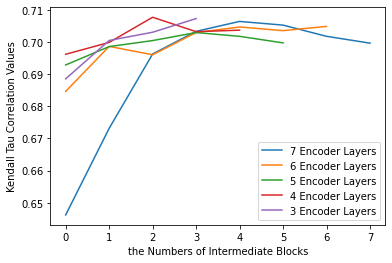

In [59]:
#Plot the chart about the different numbers of intermediate blocks with 8 Encoder Layers vs Kendall Tau Correlation
fig, ax = plt.subplots()
x = np.arange(2,8,1)
ax.plot(kt_error_n, label='7 Encoder Layers')
ax.plot(kt_error_7, label='6 Encoder Layers')
ax.plot(kt_error_6, label='5 Encoder Layers')
ax.plot(kt_error_5, label='4 Encoder Layers')
ax.plot(kt_error_4, label='3 Encoder Layers')
#plt.xlim(2,7)
plt.xlabel('the Numbers of Intermediate Blocks')
plt.ylabel('Kendall Tau Correlation Values')
ax.legend()

In [ ]:
#Get errors of the different numbers of intermediate blocks with 12 encoder layers
train_error = []
vali_error = []
kt_error = []
time_list = []
for num_layers_to_keep in range(13):
    #mstart = torch.cuda.memory_allocated(torch.cuda.current_device())
    model = MarkdownModel(deletelayers, num_layers_to_keep,0)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error.append(train_MSE)
    vali_error.append(vali_MSE)
    time_list.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #mend = torch.cuda.memory_allocated(torch.cuda.current_device())
    print("torch.cuda.memory_allocated: %fKB"%(torch.cuda.memory_allocated(0)))
    print("torch.cuda.memory_reserved: %fKB"%(torch.cuda.memory_reserved(0)))
    print("torch.cuda.max_memory_reserved: %fKB"%(torch.cuda.max_memory_reserved(0)))
    
#print(np.mean(train_error)) 
#print(np.mean(vali_error))

In [ ]:
#Get the time decrese for the different numbers of intermediate blocks with 12 encoder layers
t_ans = []
for i in range(13):
    t_ans.append((time_list[12] - time_list[i]) / time_list[12])
t_ans

In [ ]:
#Get the size decrese for the different numbers of intermediate blocks with 12 encoder layers
si_ans = []
size_i = [67.37,72.09,76.81,81.54,86.26,90.99,95.71,100.43,105.16,109.88,114.61,119.33,124.05]
for i in range(12,-1,-1):
    si_ans.append((size_i[12] - size_i[i]) / size_i[12])
si_ans

In [ ]:
fig, ax = plt.subplots() 
x = np.arange(0,13,1)
ax.plot(kt_error, label='Kendall Tau Correlation')
ax.plot(t_ans, label='Running Time Increase')
ax.plot(si_ans, label='Size Decrease')
ax.legend(loc='upper left')
plt.xlabel('the Numbers of Intermediate Blocks')
plt.ylabel('Values')

In [ ]:
##Get errors of the different numbers of encoder layers
train_error_l = []
vali_error_l = []
kt_error_l = []
time_list_l = []
for num_layers_to_keep in range(1,13):
    model = MarkdownModel(deletelayers_layer, num_layers_to_keep,12)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_l.append(train_MSE)
    vali_error_l.append(vali_MSE)
    time_list_l.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_l.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))

In [ ]:
fig, ax = plt.subplots() 
x = np.linspace(0,13) 
ax.plot(kt_error_a)
ax.legend(loc='upper left')
plt.xlabel('the Numbers of Self-attention Blocks')
plt.ylabel('Kendall Tau Correlation')

In [ ]:
fig, ax = plt.subplots()
y1 = kt_error_l
ax.plot( y1, label='linear') 

In [ ]:
#Get the time decrease for the different numbers of encoder layers
time_l_d = []
for i in range(13):
    time_l_d.append(round(time_list_l[12]/time_list_l[i],2))
time_l_d